# Convolutional Autoencoder ver. 3.0

## 1. initialize

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import time as tm
import os
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

In [2]:
np.random.seed(1) # to make the results reproducible

In [3]:
# TensorFlow 2.1, Keras - workaround:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [4]:
# Detect the number of train data mini batches. Shuffle them and divide into a train/test parts.

fname_pattern = "./bengaliai-cv19/train_batch_{:03d}.pickle"
train_test_split = 0.7

mbatch_no = 0
while os.path.exists(fname_pattern.format(mbatch_no)):
    mbatch_no = mbatch_no + 1
print("{} train data file(s) found.".format(mbatch_no))

mbatch_train_no = round(mbatch_no * 0.7)
mbatch_test_no = mbatch_no - mbatch_train_no
mbatch_idx = np.random.permutation(mbatch_no)
mbatch_train_idx = mbatch_idx[:mbatch_train_no]
mbatch_test_idx = mbatch_idx[mbatch_train_no:]

197 train data file(s) found.


## 2. Helper functions

In [5]:
def load_batch(mbatch_no):
    fname = fname_pattern.format(mbatch_no)
    with open(fname, "rb") as f:
        batch = pickle.load(f)
        return batch

In [6]:
def prepare_image(img):
    pil_img = PIL.Image.fromarray(img)
    new_pil_img = pil_img.resize((256, 256), PIL.Image.ANTIALIAS)
    return np.array(new_pil_img)

In [7]:
def prepare_batch(batch):
    new_X = np.zeros((batch['X'].shape[0], 256, 256), dtype=float)
    for i in range(new_X.shape[0]):
        new_X[i, :, :] = prepare_image(batch['X'][i, :, :])
    batch['X'] = new_X

In [8]:
def show_model(model):
    return SVG(model_to_dot(model, show_shapes=True, dpi=64).create(prog='dot', format='svg'))

In [9]:
def show_weights(conv2dlayer):
    _, _, inpf, outpf = conv2dlayer.get_weights()[0].shape
    for o in range(outpf):
        for i in range(inpf):
            plt.subplot(inpf * outpf // 8, 8, i + o * inpf + 1)
            plt.imshow(conv2dlayer.get_weights()[0][:, :, i, o])

## 3. Model v. 3.0

In [10]:
X = tf.keras.layers.Input(shape=[256, 256, 1], dtype=tf.float32)

Z1 = tf.keras.layers.Conv2D(filters=4, kernel_size=[9,9], strides=[1,1], padding="same", dilation_rate=[1,1])(X)
B1 = tf.keras.layers.BatchNormalization(axis=3)(Z1)
A1 = tf.keras.layers.LeakyReLU(alpha=0.1)(B1)
P1 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A1)

Z2 = tf.keras.layers.Conv2D(filters=8, kernel_size=[9,9], strides=[1,1], padding="same", dilation_rate=[1,1])(P1)
B2 = tf.keras.layers.BatchNormalization(axis=3)(Z2)
A2 = tf.keras.layers.LeakyReLU(alpha=0.1)(B2)
P2 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A2)

Z3 = tf.keras.layers.Conv2D(filters=16, kernel_size=[9,9], strides=[1,1], padding="same", dilation_rate=[1,1])(P2)
B3 = tf.keras.layers.BatchNormalization(axis=3)(Z3)
A3 = tf.keras.layers.LeakyReLU(alpha=0.1)(B3)
P3 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A3)

Z4 = tf.keras.layers.Conv2D(filters=16, kernel_size=[9,9], strides=[1,1], padding="same", dilation_rate=[1,1])(P3)
B4 = tf.keras.layers.BatchNormalization(axis=3)(Z4)
A4 = tf.keras.layers.LeakyReLU(alpha=0.1)(B4)
P4 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A4)

Z5 = tf.keras.layers.Conv2D(filters=16, kernel_size=[9,9], strides=[1,1], padding="same", dilation_rate=[1,1])(P4)
B5 = tf.keras.layers.BatchNormalization(axis=3)(Z5)
A5 = tf.keras.layers.LeakyReLU(alpha=0.1)(B5)
P5 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A5)

Z6 = tf.keras.layers.Conv2D(filters=16, kernel_size=[9,9], strides=[1,1], padding="same", dilation_rate=[1,1])(P5)
B6 = tf.keras.layers.BatchNormalization(axis=3)(Z6)
A6 = tf.keras.layers.LeakyReLU(alpha=0.1)(B6)
P6 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")(A6)

Z7 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=[9,9], padding="same")(P6)
B7 = tf.keras.layers.BatchNormalization(axis=3)(Z7)
A7 = tf.keras.layers.LeakyReLU(alpha=0.1)(B7)
U7 = tf.keras.layers.UpSampling2D(size=(2, 2))(A7)

Z8 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=[9,9], padding="same")(U7)
B8 = tf.keras.layers.BatchNormalization(axis=3)(Z8)
A8 = tf.keras.layers.LeakyReLU(alpha=0.1)(B8)
U8 = tf.keras.layers.UpSampling2D(size=(2, 2))(A8)

Z9 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=[9,9], padding="same")(U8)
B9 = tf.keras.layers.BatchNormalization(axis=3)(Z9)
A9 = tf.keras.layers.LeakyReLU(alpha=0.1)(B9)
U9 = tf.keras.layers.UpSampling2D(size=(2, 2))(A9)

Z10 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=[9,9], padding="same")(U9)
B10 = tf.keras.layers.BatchNormalization(axis=3)(Z10)
A10 = tf.keras.layers.LeakyReLU(alpha=0.1)(B10)
U10 = tf.keras.layers.UpSampling2D(size=(2, 2))(A10)

Z11 = tf.keras.layers.Conv2DTranspose(filters=4, kernel_size=[9,9], padding="same")(U10)
B11 = tf.keras.layers.BatchNormalization(axis=3)(Z11)
A11 = tf.keras.layers.LeakyReLU(alpha=0.1)(B11)
U11 = tf.keras.layers.UpSampling2D(size=(2, 2))(A11)

Z12 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=[9,9], padding="same")(U11)
B12 = tf.keras.layers.BatchNormalization(axis=3)(Z12)
A12 = tf.keras.layers.LeakyReLU(alpha=0.1)(B12)
U12 = tf.keras.layers.UpSampling2D(size=(2, 2))(A12)

model = tf.keras.models.Model(inputs=X, outputs=U12) # Keras 2.2.4 from TensorFlow 2.1.0
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.0), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 4)       328       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 4)       16        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 4)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       2600      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 8)       32    

In [11]:
def fit(img_batch, idx_from, idx_to, epochs):
    mini_img_batch = img_batch[idx_from:idx_to, :, :]
    mini_batch = mini_img_batch.reshape(mini_img_batch.shape[0], mini_img_batch.shape[1], mini_img_batch.shape[2], 1)
    input_X = tf.convert_to_tensor(mini_batch, dtype=tf.float32)
    model.fit(input_X, input_X, epochs=epochs)

In [12]:
def predict(img):
    inp_img = img.reshape(1, img.shape[0], img.shape[1], 1)
    pred_img = model.predict(inp_img)
    ret_img = pred_img.reshape(img.shape[0], img.shape[1])
    return ret_img

## 4. Train

In [13]:
for i, idx in enumerate(mbatch_train_idx):
    print("Batch# {}".format(idx), flush=True)
    batch = load_batch(idx)
    prepare_batch(batch)
    fit(batch['X'], 0, 1024, epochs=50)
    model.save("output/model-v3.0-{}-{}.h5".format(tm.time(), i))

Batch# 35
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 6s 6ms/sample - loss: 0.3437 - accuracy: 0.2291
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.1719 - accuracy: 0.2808
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0964 - accuracy: 0.2845
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0645 - accuracy: 0.2846
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0706 - accuracy: 0.2822
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0500 - accuracy: 0.2848
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0423 - accuracy: 0.2852
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0388 - accuracy: 0.2852
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0343 - accuracy: 0.2852
Epoch 10/50
1024/1024 [=========

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0153 - accuracy: 0.2658
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0152 - accuracy: 0.2658
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0150 - accuracy: 0.2658
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0149 - accuracy: 0.2658
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0148 - accuracy: 0.2658
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0148 - accuracy: 0.2658
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0146 - accuracy: 0.2658
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0146 - accuracy: 0.2658
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0146 - accuracy: 0.2658
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0128 - accuracy: 0.2756
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0126 - accuracy: 0.2756
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0124 - accuracy: 0.2756
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0124 - accuracy: 0.2756
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0124 - accuracy: 0.2756
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0121 - accuracy: 0.2756
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0121 - accuracy: 0.2756
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0122 - accuracy: 0.2756
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0119 - accuracy: 0.2756
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample 

Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0091 - accuracy: 0.2956
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0092 - accuracy: 0.2956
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0089 - accuracy: 0.2956
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0090 - accuracy: 0.2956
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0089 - accuracy: 0.2956
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0090 - accuracy: 0.2956
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0090 - accuracy: 0.2956
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0089 - accuracy: 0.2956
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0089 - accuracy: 0.2956
Epoch 42/50
1024/1024 [==============================] 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0089 - accuracy: 0.2833
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0088 - accuracy: 0.2833
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0088 - accuracy: 0.2833
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0087 - accuracy: 0.2833
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0086 - accuracy: 0.2833
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0085 - accuracy: 0.2833
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0085 - accuracy: 0.2833
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0085 - accuracy: 0.2833
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0083 - accuracy: 0.2833
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0070 - accuracy: 0.2798
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0071 - accuracy: 0.2798
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0071 - accuracy: 0.2798
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0071 - accuracy: 0.2798
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0071 - accuracy: 0.2798
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0071 - accuracy: 0.2798
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0070 - accuracy: 0.2798
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0070 - accuracy: 0.2798
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0069 - accuracy: 0.2798
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0074 - accuracy: 0.2690
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0073 - accuracy: 0.2690
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0073 - accuracy: 0.2690
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0073 - accuracy: 0.2690
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0072 - accuracy: 0.2690
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0072 - accuracy: 0.2690
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0072 - accuracy: 0.2690
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0071 - accuracy: 0.2690
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0071 - accuracy: 0.2690
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0062 - accuracy: 0.2774
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0062 - accuracy: 0.2774
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0062 - accuracy: 0.2774
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0062 - accuracy: 0.2774
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0062 - accuracy: 0.2774
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0061 - accuracy: 0.2774
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0061 - accuracy: 0.2774
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0061 - accuracy: 0.2774
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0060 - accuracy: 0.2774
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0065 - accuracy: 0.2615
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0064 - accuracy: 0.2615
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0064 - accuracy: 0.2615
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0062 - accuracy: 0.2615
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0061 - accuracy: 0.2615
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0061 - accuracy: 0.2615
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0062 - accuracy: 0.2615
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0061 - accuracy: 0.2615
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0061 - accuracy: 0.2615
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2774
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2774
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0053 - accuracy: 0.2774
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0052 - accuracy: 0.2774
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0053 - accuracy: 0.2774
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0052 - accuracy: 0.2774
Batch# 31
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0083 - accuracy: 0.2879
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0076 - accuracy: 0.2879
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0074 - accuracy: 0.2879
Epoch 4/50
1024/1024 [================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0057 - accuracy: 0.2682
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0057 - accuracy: 0.2682
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0057 - accuracy: 0.2682
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0058 - accuracy: 0.2682
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0057 - accuracy: 0.2682
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0056 - accuracy: 0.2682
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0055 - accuracy: 0.2682
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0055 - accuracy: 0.2682
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0055 - accuracy: 0.2682
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0051 - accuracy: 0.2862
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0050 - accuracy: 0.2862
Batch# 53
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0080 - accuracy: 0.2928
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0074 - accuracy: 0.2928
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0072 - accuracy: 0.2928
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0070 - accuracy: 0.2928
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0069 - accuracy: 0.2928
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0067 - accuracy: 0.2928
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0066 - accuracy: 0.2928
Epoch 8/50
1024/1024 [====================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2738
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2738
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0055 - accuracy: 0.2738
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2738
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0053 - accuracy: 0.2738
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2738
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0055 - accuracy: 0.2738
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0053 - accuracy: 0.2738
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0052 - accuracy: 0.2738
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0063 - accuracy: 0.2889
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0062 - accuracy: 0.2889
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0062 - accuracy: 0.2889
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0060 - accuracy: 0.2889
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0058 - accuracy: 0.2889
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0058 - accuracy: 0.2889
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0057 - accuracy: 0.2889
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0057 - accuracy: 0.2889
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0056 - accuracy: 0.2889
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - 

Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2710
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2710
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2710
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2710
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2710
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2710
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2710
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2710
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2710
Epoch 40/50
1024/1024 [==============================] 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0057 - accuracy: 0.2749
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0056 - accuracy: 0.2749
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0056 - accuracy: 0.2749
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0056 - accuracy: 0.2749
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0055 - accuracy: 0.2749
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2749
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2749
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2749
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2749
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/samp

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2750
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2750
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2750
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2750
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2750
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2750
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2750
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2750
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2750
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0053 - accuracy: 0.2860
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0053 - accuracy: 0.2860
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0052 - accuracy: 0.2860
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0052 - accuracy: 0.2860
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0052 - accuracy: 0.2860
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0051 - accuracy: 0.2860
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0051 - accuracy: 0.2860
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0050 - accuracy: 0.2860
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0050 - accuracy: 0.2860
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2845
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2845
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2845
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2845
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2845
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2845
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2845
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2845
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2845
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0050 - accuracy: 0.2987
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2987
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0050 - accuracy: 0.2987
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2987
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2987
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2987
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2987
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2987
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2987
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2958
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2958
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2958
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2958
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2958
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2958
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2958
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2958
Batch# 4
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0060 - accuracy: 0.2505
Epoch 2/50
1024/1024 [===============

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2823
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2823
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2823
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2823
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2823
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2823
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2823
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2823
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2823
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2752
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2752
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2752
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2752
Batch# 102
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0060 - accuracy: 0.2836
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0057 - accuracy: 0.2836
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0055 - accuracy: 0.2836
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2836
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0053 - accuracy: 0.2836
Epoch 6/50
1024/1024 [=================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2802
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2802
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2802
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2802
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2802
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2802
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2802
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2802
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2802
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0058 - accuracy: 0.2613
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0054 - accuracy: 0.2613
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0052 - accuracy: 0.2613
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0051 - accuracy: 0.2613
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2613
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2613
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2613
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2613
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2613
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - lo

Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2746
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2746
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2746
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2746
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2746
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2746
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2746
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2746
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2746
Epoch 38/50
1024/1024 [==============================] 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2817
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2817
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2817
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2817
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2817
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2817
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2817
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2817
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2817
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample

Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2761
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2761
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2761
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2761
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2761
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2761
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2761
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2761
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2761
Epoch 43/50
1024/1024 [==============================] 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2728
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2728
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2728
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2728
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2728
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2728
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2728
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2728
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2728
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2975
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2975
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2975
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2975
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2975
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2975
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2975
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2975
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2975
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2845
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2845
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2845
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2845
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2845
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2845
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2845
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2845
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2845
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2813
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2813
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2813
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2813
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2813
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2813
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2813
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2813
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2813
Batch# 160
Train on 1024 samples
Epoch 1/50
1024/1024 [============

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2978
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2978
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2978
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2978
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2978
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2978
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2978
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2978
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2978
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2900
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2900
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2900
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2900
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2900
Batch# 94
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0055 - accuracy: 0.2966
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0052 - accuracy: 0.2966
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0050 - accuracy: 0.2966
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2966
Epoch 5/50
1024/1024 [=================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2661
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2661
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2661
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2661
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2661
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2661
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2661
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2661
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2661
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2877
Batch# 155
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0055 - accuracy: 0.2841
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0052 - accuracy: 0.2841
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0050 - accuracy: 0.2841
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2841
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2841
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2841
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2841
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2841
Epoch 9/50
1024/1024 [====================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2805
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2805
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2805
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2805
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2805
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2805
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2805
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2805
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2805
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2851
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2851
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2851
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2851
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2851
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2851
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2851
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2851
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2851
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample 

Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2981
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2981
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2981
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2981
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2981
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2981
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2981
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2981
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2981
Epoch 42/50
1024/1024 [==============================] 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2747
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2747
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2747
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2747
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2747
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2747
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2747
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2747
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2747
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2727
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2727
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2727
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2727
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2727
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2727
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2727
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2727
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2727
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2698
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2698
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2698
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2698
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2698
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2698
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2698
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2698
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2698
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2622
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2622
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2622
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2622
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2622
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2622
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2622
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2622
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2622
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2724
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2724
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2724
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2724
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2724
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2724
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2724
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2724
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2724
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2770
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2770
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2770
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2770
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2770
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2770
Batch# 54
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0051 - accuracy: 0.2914
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0049 - accuracy: 0.2914
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2914
Epoch 4/50
1024/1024 [================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2727
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2727
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2727
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2727
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2727
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2727
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2727
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2727
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2727
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2676
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2676
Batch# 78
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0050 - accuracy: 0.2782
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2782
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2782
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2782
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2782
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2782
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2782
Epoch 8/50
1024/1024 [====================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2905
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2905
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2905
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2905
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2905
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2905
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2905
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2905
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2905
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2820
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2820
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2820
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2820
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2820
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2820
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2820
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2820
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2820
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - 

Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2797
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2797
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2797
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2797
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2797
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2797
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2797
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2797
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2797
Epoch 40/50
1024/1024 [==============================] 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2671
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2671
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2671
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2671
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2671
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2671
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2671
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2671
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2671
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/samp

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2930
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2930
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2930
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2930
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2930
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2930
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2930
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2930
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2930
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2816
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2816
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2816
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2816
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2816
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2816
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2816
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2816
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2816
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2858
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2858
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2858
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2858
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2858
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2858
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2858
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2858
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2858
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2804
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2804
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2804
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2804
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2804
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2804
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2804
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2804
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2804
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2883
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2883
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2883
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2883
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2883
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2883
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2883
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2883
Batch# 176
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0048 - accuracy: 0.2878
Epoch 2/50
1024/1024 [=============

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2649
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2649
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2649
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2649
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2649
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2649
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2649
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2649
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2649
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2791
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2791
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2791
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2791
Batch# 36
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2913
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2913
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2913
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2913
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2913
Epoch 6/50
1024/1024 [==================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2763
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2763
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2763
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2763
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2763
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2763
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2763
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2763
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2763
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0050 - accuracy: 0.2772
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2772
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2772
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2772
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2772
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2772
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2772
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2772
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2772
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - lo

Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2707
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2707
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2707
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2707
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2707
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2707
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2707
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2707
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2707
Epoch 38/50
1024/1024 [==============================] 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2675
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2675
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2675
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2675
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2675
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2675
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2675
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2675
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2675
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample

Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2881
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2881
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2881
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2881
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2881
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2881
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2881
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2881
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2881
Epoch 43/50
1024/1024 [==============================] 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2832
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2832
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2832
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2832
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2832
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2832
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2832
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2832
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2832
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2782
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2782
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2782
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2782
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2782
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2782
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2782
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2782
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2782
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.28 - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2820
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2820
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2820
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2820
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2820
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2820
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2820
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2820
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2820
Epoch 24/50
1024/1024 [==

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2696
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2696
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2696
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2696
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2696
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2696
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2696
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2696
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2696
Batch# 70
Train on 1024 samples
Epoch 1/50
1024/1024 [=============

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2958
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2958
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2958
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2958
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2958
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2958
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2958
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2958
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2958
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2912
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2912
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2912
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2912
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2912
Batch# 6
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2738
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2738
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2738
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2738
Epoch 5/50
1024/1024 [==================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2946
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2946
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2946
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2946
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2946
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2946
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2946
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2946
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2946
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2711
Batch# 153
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0047 - accuracy: 0.2730
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0045 - accuracy: 0.2730
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2730
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2730
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2730
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2730
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2730
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2730
Epoch 9/50
1024/1024 [====================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2725
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2725
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2725
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2725
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2725
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2725
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2725
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2725
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2725
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2841
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2841
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2841
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2841
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2841
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2841
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2841
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2841
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2841
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample -

Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2701
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2701
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2701
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2701
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2701
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2701
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2701
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2701
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2701
Epoch 41/50
1024/1024 [==============================] 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2898
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2898
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2898
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2898
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2898
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2898
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2898
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2898
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2898
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2812
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2812
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2812
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2812
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2812
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2812
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2812
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2812
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2812
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2915
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2915
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2915
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2915
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2915
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2915
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2915
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2915
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2915
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2864
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2864
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2864
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2864
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2864
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2864
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2864
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2864
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2864
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2874
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2874
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2874
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2874
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2874
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2874
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2874
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2874
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2874
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2831
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2831
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2831
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2831
Epoch 48/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2831
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2831
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2831
Batch# 87
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2806
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2806
Epoch 3/50
1024/1024 [===============

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2799
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2799
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2799
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2799
Epoch 25/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2799
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2799
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2799
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2799
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2799
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2943
Epoch 49/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2943
Epoch 50/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2943
Batch# 192
Train on 1024 samples
Epoch 1/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0046 - accuracy: 0.2825
Epoch 2/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2825
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0042 - accuracy: 0.2825
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2825
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2825
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2825
Epoch 7/50
1024/1024 [==================

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2795
Epoch 26/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2795
Epoch 27/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2795
Epoch 28/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2795
Epoch 29/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2795
Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2795
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2795
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2795
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2795
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0044 - accuracy: 0.2798
Epoch 3/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0043 - accuracy: 0.2798
Epoch 4/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2798
Epoch 5/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0041 - accuracy: 0.2798
Epoch 6/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2798
Epoch 7/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2798
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2798
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2798
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2798
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - l

Epoch 30/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2872
Epoch 31/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2872
Epoch 32/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2872
Epoch 33/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2872
Epoch 34/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2872
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2872
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2872
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2872
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2872
Epoch 39/50
1024/1024 [==============================] 

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0040 - accuracy: 0.2922
Epoch 8/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2922
Epoch 9/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2922
Epoch 10/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0039 - accuracy: 0.2922
Epoch 11/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2922
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2922
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2922
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2922
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2922
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sampl

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2881
Epoch 35/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2881
Epoch 36/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2881
Epoch 37/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2881
Epoch 38/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2881
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2881
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2881
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2881
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2881
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2956
Epoch 12/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0038 - accuracy: 0.2956
Epoch 13/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2956
Epoch 14/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2956
Epoch 15/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2956
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2956
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2956
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2956
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2956
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2699
Epoch 39/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2699
Epoch 40/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2699
Epoch 41/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2699
Epoch 42/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2699
Epoch 43/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2699
Epoch 44/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2699
Epoch 45/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0033 - accuracy: 0.2699
Epoch 46/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0034 - accuracy: 0.2699
Epoch 47/50
1024/1024 [==============================] - 1s 1ms/sam

1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2807
Epoch 16/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2807
Epoch 17/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2807
Epoch 18/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2807
Epoch 19/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2807
Epoch 20/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0037 - accuracy: 0.2807
Epoch 21/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2807
Epoch 22/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0036 - accuracy: 0.2807
Epoch 23/50
1024/1024 [==============================] - 1s 1ms/sample - loss: 0.0035 - accuracy: 0.2807
Epoch 24/50
1024/1024 [==============================] - 1s 1ms/sam

In [14]:
model.save("output/model-v3.0.h5")

## 5. Verify

In [15]:
test_batch = load_batch(mbatch_test_idx[0])
prepare_batch(test_batch)

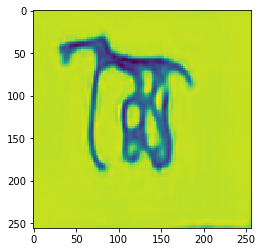

In [16]:
plt.imshow(predict(test_batch['X'][0]))

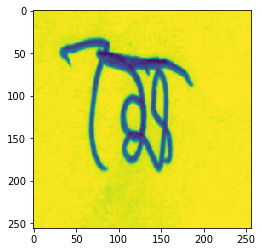

In [17]:
plt.imshow(test_batch['X'][0])